# Setup

In [1]:
import gc
import random

import astropy.units as u
import ipywidgets as widgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import sunpy.map
import sunpy.visualization.colormaps.color_tables as ct
from astropy.visualization import AsinhStretch, ImageNormalize
from IPython.display import clear_output, display
from matplotlib.patches import Rectangle
from sunpy.coordinates import frames
from tqdm import tqdm
import json
from pathlib import Path

from contextlib import contextmanager

# plotting defaults
mpl.rcParams["lines.markersize"] = 2  # default is 6


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from Library.Processing import *
from Library.IO import *
from Library.Model import *
from Library.Metrics import *
from Library.Config import *
from Library.CH import *
from Library.Plot import *

/opt/homebrew/Caskroom/miniconda/base/envs/icme3.12-metal/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# CH Stats

In [4]:
# import sys, subprocess

# subprocess.run(
#     [sys.executable, "-m", "Scripts.Make", "Stats", "A1", "D1", "P1"],
#     check=True,
# )

In [5]:
df_p = pd.read_parquet(paths["artifact_root"] + "Paths.parquet")
print(f"Loaded {len(df_p)} paths from Paths.parquet")

Loaded 20166 paths from Paths.parquet


In [6]:
from Models import load_date_range

# Add/remove specs here
specs = ["A2D2", "A2D1", "A1D1"]
postprocessing = "P1"


def parse_spec(spec):
    spec = spec.strip()
    if len(spec) < 4:
        raise ValueError(f"Invalid spec: {spec}")
    arch_id = spec[:2]
    date_id = spec[2:]
    return arch_id, date_id


def find_stats_path(arch_id, date_id, postprocessing):
    root = Path("./Outputs") / "Stats"
    candidates = [
        root / f"{arch_id}{date_id}{postprocessing} Stats.parquet",
        root / f"{arch_id}{date_id}{postprocessing}_stats.parquet",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"No stats parquet found for {arch_id}{date_id}{postprocessing} in {root}"
    )


def prepare_stats_df(df):
    df = df.copy()
    df.index.name = "key"

    dt_index = pd.to_datetime(df.index.str[:13], format="%Y%m%d_%H%M", errors="coerce")
    df = df[~dt_index.isna()].copy()
    df["time"] = dt_index[~dt_index.isna()]
    df = df.sort_values("time")

    stats_df = df.filter(like="oval")
    stats_df.index = df["time"]
    stats_df.columns = stats_df.columns.str.replace("_oval", "", regex=False)

    stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
    stats_df.index = pd.to_datetime(stats_df.index, format="%Y%m%d_%H%M")
    stats_df = stats_df.resample("27d").median()
    return df, stats_df


stats_data = {}
for spec in specs:
    arch_id, date_id = parse_spec(spec)
    stats_path = find_stats_path(arch_id, date_id, postprocessing)
    df = pd.read_parquet(stats_path)
    df, stats_df = prepare_stats_df(df)

    date_range = load_date_range(arch_id, date_id)
    train_df, _ = date_range.select_pairs(df_p)

    stats_data[spec] = {
        "df": df,
        "stats_df": stats_df,
        "train_df": train_df,
        "path": stats_path,
    }

list(stats_data.keys())

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_89729/321932717.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_89729/321932717.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.rel_area = stats_df.rel_area.replace([np.inf, -np.inf], np.nan)
/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_89729/321932717.py:44: SettingWithCopyWarning: 
A v

['A2D2', 'A2D1', 'A1D1']

/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_89729/1178202865.py:193: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



/var/folders/3z/b4fclst96kbd90mb019v618m0000gn/T/ipykernel_89729/1178202865.py:193: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



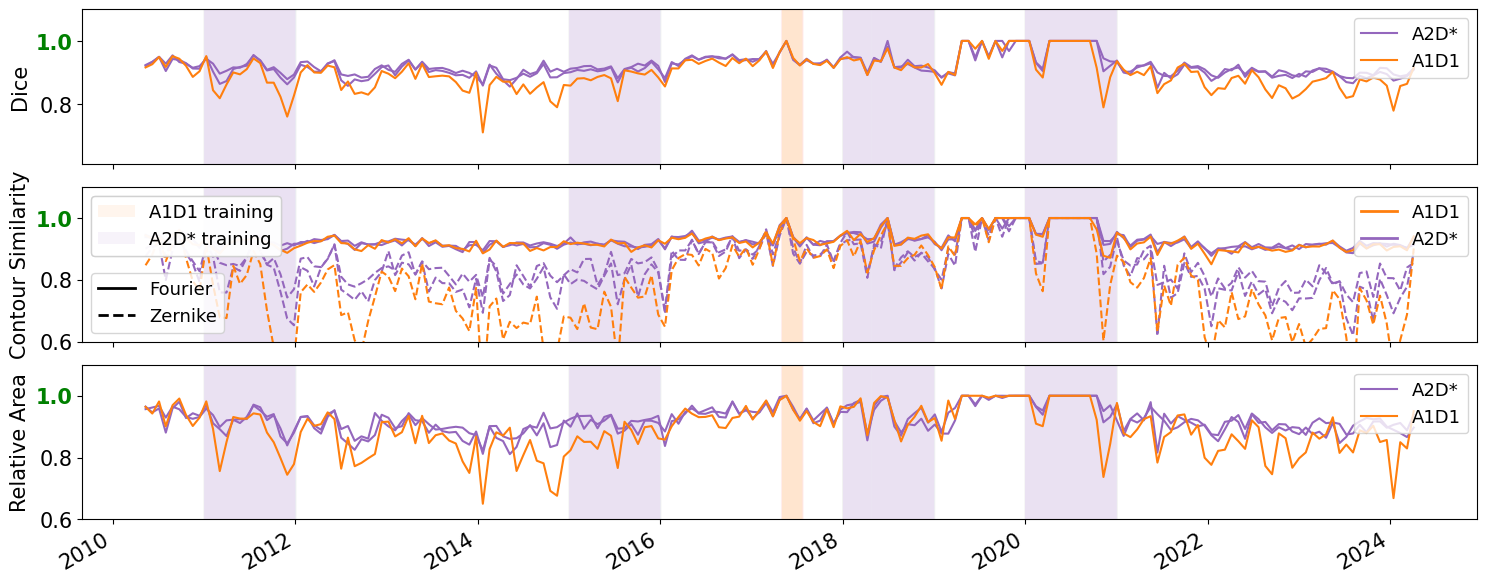

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(18, 7.5), sharex=True, gridspec_kw={"hspace": 0.15}
)

# Control smart Y-axis clipping (clips each axis to actual min - 0.1 or 0.6, whichever is higher)
smart_y_clip = True

# palette
palette = sns.color_palette("tab10", 10)
spec_to_color = {
    "A1D1": palette[1],   # orange
    "A2D1": palette[0],   # muted blue
    "A2D2": palette[4],   # purple
}

def pale(color, amt=0.65):
    rgb = np.array(mcolors.to_rgb(color))
    return tuple((1 - amt) * rgb + amt * np.ones(3))


def highlight_tick(ax, value, color="green", weight="bold"):
    """Highlight a specific tick value on the y-axis."""
    # Force a draw to populate tick labels
    plt.draw()
    for label in ax.get_yticklabels():
        try:
            if abs(float(label.get_text()) - value) < 0.01:  # small tolerance
                label.set_color(color)
                label.set_fontweight(weight)
        except (ValueError, AttributeError):
            pass

# Collect data for y-axis trimming
ax1_vals = []
ax2_vals = []
ax3_vals = []

# ====================================================
# AXIS 1 — Dice
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    color = spec_to_color.get(label, "gray")

    if "dice" in stats_df:
        dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
        ax1_vals.extend(dice_clean.values)
        ax1.plot(dice_clean.index, dice_clean, label=f"{label}", color=color, alpha=1)

ax1.set_ylabel("Dice", fontsize=15)
ax1.tick_params(axis="both", labelsize=15)
ax1.legend(loc="upper right", fontsize=13)
if smart_y_clip and ax1_vals:
    ax1_min = max(0.6, np.nanmin(ax1_vals) - 0.1)
else:
    ax1_min = 0
ax1.set_ylim(ax1_min, 1.1)

# ====================================================
# AXIS 2 — Contour Similarity (1 - distance)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    color = spec_to_color.get(label, "gray")

    if "fourier_distance" in stats_df:
        fd_clean = (1 - stats_df["fourier_distance"]).replace([0], pd.NA).dropna()
        ax2_vals.extend(fd_clean.values)
        ax2.plot(fd_clean.index, fd_clean, color=color, linestyle="-", alpha=1)

    if "zernike_distance" in stats_df:
        zd_clean = (1 - stats_df["zernike_distance"]).replace([0], pd.NA).dropna()
        ax2_vals.extend(zd_clean.values)
        ax2.plot(zd_clean.index, zd_clean, color=color, linestyle="--", alpha=1)

ax2.set_ylabel("Contour Similarity", fontsize=15)
ax2.tick_params(axis="both", labelsize=15)
if smart_y_clip and ax2_vals:
    ax2_min = max(0.6, np.nanmin(ax2_vals) - 0.1)
else:
    ax2_min = 0
ax2.set_ylim(ax2_min, 1.1)

# dataset legend: three solid lines only
dataset_handles = [
    plt.Line2D([0], [0], color=spec_to_color.get(lbl, "gray"), lw=2, linestyle="-")
    for lbl in ["A1D1", "A2D1", "A2D2"]
    if lbl in stats_data
]
dataset_labels = [lbl for lbl in ["A1D1", "A2D1", "A2D2"] if lbl in stats_data]
dataset_legend = ax2.legend(dataset_handles, dataset_labels, loc="upper right", fontsize=13)

# style legend: top-left
style_handles = [
    plt.Line2D([0], [0], color="black", lw=2, linestyle="-"),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="--"),
]
style_labels = ["Fourier", "Zernike"]
style_legend = ax2.legend(style_handles, style_labels, loc="upper left", fontsize=13)
ax2.add_artist(dataset_legend)

# ====================================================
# AXIS 3 — Relative Area (displayed as 1 - rel_area)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]
    color = spec_to_color.get(label, "gray")

    if "rel_area" in stats_df:
        # rel = (1 - np.abs(stats_df["rel_area"])).replace([1], pd.NA).dropna()
        rel = (1 - np.abs(stats_df["rel_area"]))
        ax3_vals.extend(rel.values)
        ax3.plot(rel.index, rel, label=f"{label}", color=color, alpha=1)

ax3.set_ylabel("Relative Area", fontsize=15)
ax3.set_xlabel(None)
ax3.tick_params(axis="both", labelsize=15)
ax3.legend(loc="upper right", fontsize=13)
if smart_y_clip and ax3_vals:
    ax3_min = max(0.6, np.nanmin(ax3_vals) - 0.1)
else:
    ax3_min = 0
ax3.set_ylim(ax3_min, 1.1)

# ====================================================
# Training interval rectangles (A1/A2 only)
# ====================================================
def add_train_spans(ax, train_df, color):
    if train_df is None or len(train_df) == 0:
        return
    t = pd.to_datetime(train_df.index, format="%Y%m%d_%H%M", errors="coerce")
    t = t.sort_values()
    i = 0
    while i < len(t):
        start = t[i]
        j = i
        while j + 1 < len(t) and (t[j + 1] - t[j]) <= pd.Timedelta("1h"):
            j += 1
        end = t[j]
        ax.axvspan(start, end, color=pale(color, 0.8), alpha=0.06, zorder=-5)
        i = j + 1

for label, data in stats_data.items():
    if label == "A2D1":
        continue  # no rectangle for A2D1
    if not (label.startswith("A1") or label.startswith("A2")):
        continue
    color = spec_to_color.get(label, "gray")
    train_df = data.get("train_df")
    for ax in (ax1, ax2, ax3):
        add_train_spans(ax, train_df, color)

fig.autofmt_xdate()
plt.tight_layout()

# highlight ticks AFTER tight_layout
highlight_tick(ax1, 1.0)
highlight_tick(ax2, 1.0)
highlight_tick(ax3, 1.0)

plt.show()


In [20]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Plotly version of the 3-panel stats plot (performance-optimized)
fig = make_subplots(
    rows=3,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.05,
)

# palette + colors (match matplotlib)
palette = sns.color_palette("tab10", 10)
spec_to_color = {
    "A1D1": palette[1],   # orange
    "A2D1": palette[0],   # muted blue
    "A2D2": palette[4],   # purple
}

spec_to_rgb = {
    k: f"rgb({int(v[0]*255)}, {int(v[1]*255)}, {int(v[2]*255)})"
    for k, v in spec_to_color.items()
}

def pale_rgb(color, amt=0.65):
    rgb = np.array(mcolors.to_rgb(color))
    pale = (1 - amt) * rgb + amt * np.ones(3)
    return f"rgb({int(pale[0]*255)}, {int(pale[1]*255)}, {int(pale[2]*255)})"

# Collect data for y-axis trimming
ax1_vals = []
ax2_vals = []
ax3_vals = []

# ====================================================
# AXIS 1 — Dice
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]['2020':'2021']
    color_rgb = spec_to_rgb.get(label, "gray")

    if "dice" in stats_df:
        dice_clean = stats_df["dice"].replace([0], pd.NA).dropna()
        ax1_vals.extend(dice_clean.values)
        fig.add_trace(
            go.Scattergl(
                x=dice_clean.index,
                y=dice_clean,
                mode="lines",
                name=label,
                line=dict(color=color_rgb),
            ),
            row=1,
            col=1,
        )

# ====================================================
# AXIS 2 — Contour Similarity (1 - distance)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]['2020':'2021']
    color_rgb = spec_to_rgb.get(label, "gray")

    if "fourier_distance" in stats_df:
        fd_clean = (1 - stats_df["fourier_distance"]).replace([0], pd.NA).dropna()
        ax2_vals.extend(fd_clean.values)
        fig.add_trace(
            go.Scattergl(
                x=fd_clean.index,
                y=fd_clean,
                mode="lines",
                name=f"{label} Fourier",
                line=dict(color=color_rgb, dash="solid"),
                showlegend=False,
            ),
            row=2,
            col=1,
        )

    if "zernike_distance" in stats_df:
        zd_clean = (1 - stats_df["zernike_distance"]).replace([0], pd.NA).dropna()
        ax2_vals.extend(zd_clean.values)
        fig.add_trace(
            go.Scattergl(
                x=zd_clean.index,
                y=zd_clean,
                mode="lines",
                name=f"{label} Zernike",
                line=dict(color=color_rgb, dash="dash"),
                showlegend=False,
            ),
            row=2,
            col=1,
        )

# Add style legend entries (Fourier/Zernike)
fig.add_trace(
    go.Scattergl(
        x=[None],
        y=[None],
        mode="lines",
        name="Fourier",
        line=dict(color="black", dash="solid"),
    ),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scattergl(
        x=[None],
        y=[None],
        mode="lines",
        name="Zernike",
        line=dict(color="black", dash="dash"),
    ),
    row=2,
    col=1,
)

# ====================================================
# AXIS 3 — Relative Area (displayed as 1 - rel_area)
# ====================================================
for label, data in stats_data.items():
    stats_df = data["stats_df"]['2020':'2021']
    color_rgb = spec_to_rgb.get(label, "gray")

    if "rel_area" in stats_df:
        # rel = (1 - np.abs(stats_df["rel_area"])).replace([1], pd.NA).dropna()
        rel = (1 - np.abs(stats_df["rel_area"]))
        ax3_vals.extend(rel.values)
        fig.add_trace(
            go.Scattergl(
                x=rel.index,
                y=rel,
                mode="lines",
                name=label,
                line=dict(color=color_rgb),
                showlegend=False,
            ),
            row=3,
            col=1,
        )

# ====================================================
# Training interval rectangles (A1/A2 only)
# ====================================================
shape_list = []

def add_train_spans_plotly(train_df, color, xref, yref):
    if train_df is None or len(train_df) == 0:
        return
    t = pd.to_datetime(train_df.index, format="%Y%m%d_%H%M", errors="coerce")
    t = t.sort_values()
    i = 0
    while i < len(t):
        start = t[i]
        j = i
        while j + 1 < len(t) and (t[j + 1] - t[j]) <= pd.Timedelta("1h"):
            j += 1
        end = t[j]
        shape_list.append(
            dict(
                type="rect",
                xref=xref,
                yref=yref,
                x0=start,
                x1=end,
                y0=0,
                y1=1,
                fillcolor=pale_rgb(color, 0.8),
                opacity=0.06,
                line_width=0,
                layer="below",
            )
        )
        i = j + 1

for label, data in stats_data.items():
    if label == "A2D1":
        continue  # no rectangle for A2D1
    if not (label.startswith("A1") or label.startswith("A2")):
        continue
    color = spec_to_color.get(label, "gray")
    train_df = data.get("train_df")
    add_train_spans_plotly(train_df, color, xref="x", yref="y")
    add_train_spans_plotly(train_df, color, xref="x2", yref="y2")
    add_train_spans_plotly(train_df, color, xref="x3", yref="y3")

# Y-axis limits
ax1_min = max(0.6, np.nanmin(ax1_vals) - 0.1) if smart_y_clip and ax1_vals else 0
ax2_min = max(0.6, np.nanmin(ax2_vals) - 0.1) if smart_y_clip and ax2_vals else 0
ax3_min = max(0.6, np.nanmin(ax3_vals) - 0.1) if smart_y_clip and ax3_vals else 0

fig.update_yaxes(title_text="Dice", range=[ax1_min, 1.1], row=1, col=1)
fig.update_yaxes(title_text="Contour Similarity", range=[ax2_min, 1.1], row=2, col=1)
fig.update_yaxes(title_text="Relative Area", range=[ax3_min, 1.1], row=3, col=1)

fig.update_layout(
    height=750,
    shapes=shape_list,
    legend=dict(
        x=0.99,
        y=0.99,
        xanchor="right",
        yanchor="top",
        font=dict(size=13),
    ),
    margin=dict(l=60, r=30, t=20, b=40),
)

fig.show()

In [17]:
data["stats_df"]['2020':'2021']

fourier_distance  zernike_distance  rel_area       iou      dice
time                                                                        
2020-01-18          0.000000          0.000000  0.000000  1.000000  1.000000
2020-02-14          0.051079          0.139097  0.036208  0.869751  0.930336
2020-03-12          0.051666          0.144831  0.061412  0.825939  0.904661
2020-04-08          0.000000          0.000000  0.000000  1.000000  1.000000
2020-05-05          0.000000          0.000000  0.000000  1.000000  1.000000
2020-06-01          0.000000          0.000000  0.000000  1.000000  1.000000
2020-06-28          0.000000          0.000000  0.000000  1.000000  1.000000
2020-07-25          0.000000          0.000000  0.000000  1.000000  1.000000
2020-08-21          0.000000          0.000000  0.000000  1.000000  1.000000
2020-09-17          0.000000          0.000000  0.000000  1.000000  1.000000
2020-10-14          0.000000          0.000000  0.000000  1.000000  1.000000
2020-11-10          0.074218          0.140500  0.049745  0.895316  0.944732
2020-12-07          0.074644          0.119750  0.031040  0.877960  0.935015
2021-01-03          0.052421          0.074244  0.080538  0.875336  0.933520
2021-01-30          0.055295          0.137236  0.129903  0.820881  0.901630
2021-02-26          0.093536          0.153754  0.076524  0.822627  0.902674
2021-03-25          0.073526          0.150167  0.086468  0.844520  0.915706
2021-04-21          0.069622          0.103883  0.072194  0.856703  0.922822
2021-05-18          0.058333          0.089522  0.036024  0.875470  0.933601
2021-06-14          0.083853          0.216283  0.059630  0.818093  0.899946
2021-07-11          0.077632          0.208087  0.080836  0.800411  0.889139
2021-08-07          0.090600          0.199170  0.110500  0.798109  0.887720
2021-09-03          0.077065          0.228384  0.102070  0.827360  0.905514
2021-09-30          0.059555          0.114319  0.085542  0.871500  0.931339
2021-10-27          0.093906          0.175091  0.074839  0.846673  0.916971
2021-11-23          0.075517          0.144964  0.079377  0.852144  0.920170
2021-12-20          0.098617          0.187584  0.096930  0.834713  0.909911

In [12]:
metrics = ["fourier_distance", "zernike_distance", "rel_area", "iou", "dice"]

rows = []
for dr in ["D1", "D2"]:
    # collect all specs that end with this date range
    dfs = []
    for spec, data in stats_data.items():
        if spec.endswith(dr):
            df = data["stats_df"][metrics].copy()
            dfs.append(df)

    if not dfs:
        rows.append(pd.Series([np.nan] * len(metrics), index=metrics, name=dr))
        continue

    combined = pd.concat(dfs)
    # aggregate across whole dataset (median is robust)
    rows.append(combined.median().rename(dr))

table = pd.concat(rows, axis=1)
table

D1        D2
fourier_distance  0.080331  0.076664
zernike_distance  0.180537  0.144860
rel_area          0.086081  0.077328
iou               0.830888  0.846122
dice              0.907633  0.916648

NameError: name 'plot_metric' is not defined

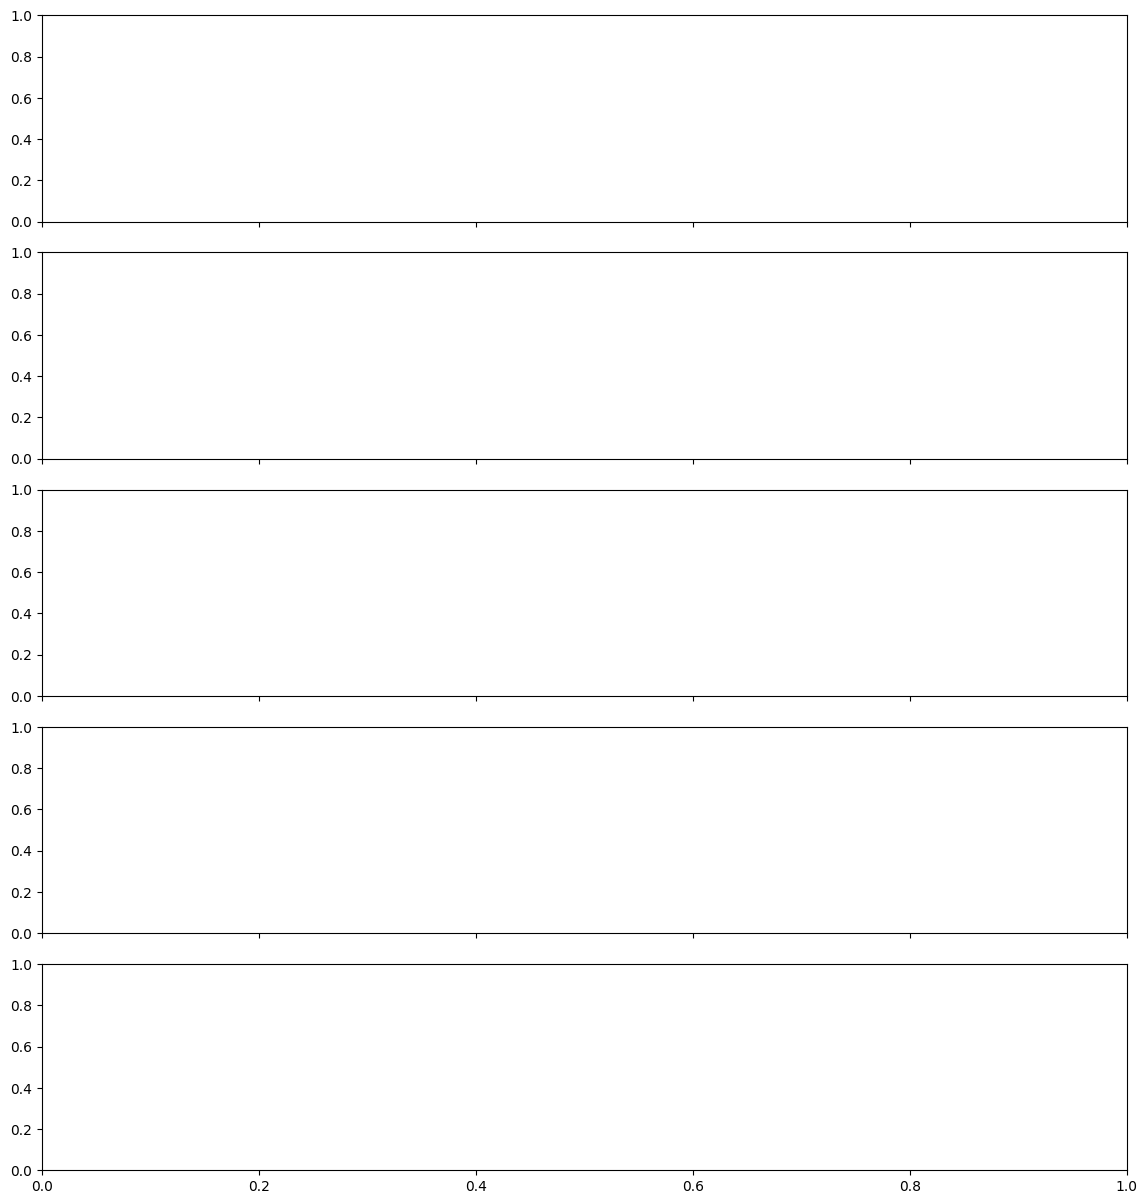

In [9]:
mpl.rcParams["lines.markersize"] = 2  # default is 6

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    5, 1, figsize=(14, 15), sharex=True, gridspec_kw={"hspace": 0.15}
)

styles = {
    "A1 D1": {"linestyle": "--", "alpha": 0.6},
    "A2 D1": {"linestyle": "-", "alpha": 0.6},
}

metric_specs = [
    ("dice", ax1, 0, False, "Dice"),
    ("iou", ax2, 0, False, "IoU"),
    ("fourier_distance", ax3, 1, False, "Fourier"),
    ("zernike_distance", ax4, 1, False, "Zernike"),
    ("rel_area", ax5, 0, True, "rel_area"),
]

for label, data in stats_data.items():
    stats_df = data["stats_df"]
    style = styles.get(label, {"linestyle": "-", "alpha": 0.6})
    for metric, ax, drop_value, abs_value, label_suffix in metric_specs:
        plot_metric(
            ax,
            stats_df,
            metric,
            label,
            style,
            drop_value=drop_value,
            abs_value=abs_value,
            label_suffix=label_suffix,
        )

ax1.axhline(1, color="green")
ax2.axhline(1, color="green")
ax1.set_ylabel("Dice")
ax2.set_ylabel("IoU")
ax1.legend(loc="upper right")
ax1.set_title("A1 vs A2 stats")

ax3.axhline(0, color="green")
ax4.axhline(0, color="green")
ax3.set_ylabel("Fourier")
ax4.set_ylabel("Zernike")
ax3.legend(loc="upper right")

ax5.axhline(0, color="green")
ax5.set_ylabel("1 - Relative Area")
ax5.set_xlabel("Time")
ax5.legend(loc="upper right")

df_for_mask = df2
times = df_for_mask["time"].to_numpy()
a1_spans = spans_from_mask(times, make_train_mask(df_for_mask, a1d1["train_df"]))
a2_spans = spans_from_mask(times, make_train_mask(df_for_mask, a2d1["train_df"]))

for ax in (ax1, ax2, ax3, ax4, ax5):
    add_spans(ax, a1_spans, color="blue", alpha=0.1, zorder=-1)
    add_spans(ax, a2_spans, color="orange", alpha=0.1, zorder=-2)

fig.autofmt_xdate()
plt.tight_layout()
plt.show()

# Luminance Analysis

In [ ]:
def init_stats():
    return {"n": 0, "mean": 0.0, "M2": 0.0, "min": np.inf, "max": -np.inf, "skipped": 0}

In [ ]:
def update_stats(stats, arr):
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return
    stats["min"] = min(stats["min"], float(arr.min()))
    stats["max"] = max(stats["max"], float(arr.max()))

    n = stats["n"]
    mean = stats["mean"]
    M2 = stats["M2"]

    batch_n = arr.size
    batch_mean = float(arr.mean())
    batch_M2 = float(arr.var(ddof=0) * batch_n)

    if n == 0:
        stats["n"] = batch_n
        stats["mean"] = batch_mean
        stats["M2"] = batch_M2
        return

    delta = batch_mean - mean
    total_n = n + batch_n
    stats["mean"] = mean + delta * batch_n / total_n
    stats["M2"] = M2 + batch_M2 + (delta * delta) * n * batch_n / total_n
    stats["n"] = total_n

In [ ]:
from collections import defaultdict

stats_by_year = defaultdict(init_stats)

In [ ]:
for idx, row in tqdm(df.iterrows(), total=len(df)):
    year = str(idx)[:4]  # index like YYYYMMDD_HHMM
    try:
        _, img = prepare_fits(row.fits_path)
    except Exception:
        stats_by_year[year]["skipped"] += 1
        continue
    update_stats(stats_by_year[year], img)

100%|██████████| 20166/20166 [00:00<00:00, 69250.20it/s]


In [ ]:
rows = []
for year, s in sorted(stats_by_year.items()):
    std = float(np.sqrt(s["M2"] / s["n"])) if s["n"] else float("nan")
    rows.append(
        {
            "year": year,
            "n": s["n"],
            "skipped": s["skipped"],
            "min": s["min"],
            "max": s["max"],
            "mean": s["mean"],
            "std": std,
        }
    )

yearly_stats = pd.DataFrame(rows)

In [ ]:
rows.to_parquet("./Outputs/Stats/Luminance.parquet")
yearly_stats

AttributeError: 'list' object has no attribute 'to_parquet'

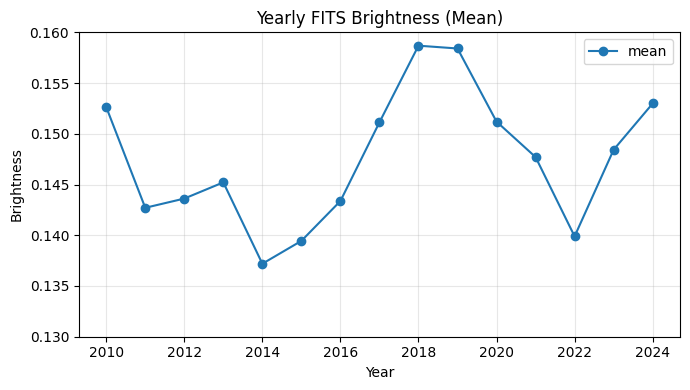

In [ ]:
import matplotlib.pyplot as plt

# Ensure year is sorted and numeric-ish for plotting
plot_df = yearly_stats.copy()
plot_df["year"] = plot_df["year"].astype(int)
plot_df = plot_df.sort_values("year")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(plot_df["year"], plot_df["mean"], marker="o", label="mean")

# ax.fill_between(
#     plot_df["year"],
#     plot_df["mean"] - plot_df["std"],
#     plot_df["mean"] + plot_df["std"],
#     alpha=0.2,
#     label="±1 std",
# )

ax.set_xlabel("Year")
ax.set_ylabel("Brightness")
ax.set_title("Yearly FITS Brightness (Mean)")
ax.grid(True, alpha=0.3)
ax.set_ylim(0.13, 0.16)
ax.legend()
plt.tight_layout()
plt.show()